In [ ]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [40]:

def process_file_path(file_path):
    groups = ["_".join(x.split("_")[:-1]) for x in os.listdir(file_path) if x != ".DS_Store"]
    dirs = [file_path + x + "/" for x in os.listdir(file_path) if x != ".DS_Store"]

    return groups, dirs


def plot_clustering_loss(file_path, figure_name, rows, columns, replicates: int = 10):

    groups, dirs = process_file_path(file_path)

    print(groups, dirs)
    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2))  # 2 rows, 5 columns

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(rows):

            to_show = random.randint(1, replicates)
            while to_show in sampled:
                to_show = random.randint(1, replicates)
            
            sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_extants_r{to_show}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def plot_standard_loss(file_path, figure_name, rows = 3, columns = 3, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2)) 

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(rows):

            to_show = random.randint(1, max_reps)
            while to_show in sampled:
                to_show = random.randint(1, max_reps)
            
            sampled.append(to_show)
            image_path = dirs[col] + f"{groups[col]}_r{to_show}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def combine_standard_replicates(file_path, max_reps: int = 15):
    
    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):

            file = dirs[g] + f"{groups[g]}_extants_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    results = pd.concat(df_list, ignore_index=True)

    print(results.shape)
    return results

def combine_clustering_replicates(file_path, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):
            file = f"{file_path + groups[g]}_sanjana/{groups[g]}_extants_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    cluster_results = pd.concat(df_list, ignore_index=True)
    print(cluster_results.shape)

    return cluster_results

def get_standard_label(lab):
        data = lab.split("/")[1].split("_")
        if len(data) == 3:
            # anc or extant
            return data[1]
        else:
            return "_".join(data[1:-1])
        

def plot_standard_metrics(std_results, protein_name):

    # use unique id to work out which sample it is 
    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get extants, ancestor or anc_extant label in sample
   

    rep = std_results["unique_id"].apply(get_rep)

    ext_prop = std_results["unique_id"].apply(get_standard_label)

    std_results["replicate"] = rep
    std_results["sample"] = ext_prop

    labels = std_results["sample"].unique()
    labels.sort()
    
    points = [std_results.loc[std_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()

    

def plot_clustering_metrics(cluster_results, protein_name):

    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get proportion of extants in sample
    get_ex = lambda x: float(x.split("/")[1].split("_")[1]) 


    rep = cluster_results["unique_id"].apply(get_rep)

    ext_prop = cluster_results["unique_id"].apply(get_ex)

    cluster_results["replicate"] = rep
    cluster_results["sample"] = ext_prop

    labels = cluster_results["sample"].unique()
    labels.sort()
    
    points = [cluster_results.loc[cluster_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()



# GB1 clustering 

#### GB1 clustering results - loss

['gb1_0.0', 'gb1_0.07', 'gb1_0.17', 'gb1_0.22', 'gb1_0.12', 'gb1_0.02'] ['/Users/sebs_mac/sanj_round_1/gb1/gb1_0.0_sanjana/', '/Users/sebs_mac/sanj_round_1/gb1/gb1_0.07_sanjana/', '/Users/sebs_mac/sanj_round_1/gb1/gb1_0.17_sanjana/', '/Users/sebs_mac/sanj_round_1/gb1/gb1_0.22_sanjana/', '/Users/sebs_mac/sanj_round_1/gb1/gb1_0.12_sanjana/', '/Users/sebs_mac/sanj_round_1/gb1/gb1_0.02_sanjana/']


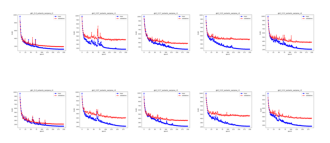

In [31]:
gb1_file_path = '/Users/sebs_mac/sanj_round_1/gb1/'
figure_name = "gb1_sanj_cluster_loss.png"

plot_clustering_loss(gb1_file_path, figure_name, rows=2, columns=5, replicates=5)

#### GB1 clustering results - metrics: 5 replicates

In [38]:
gb1_all_cluster_results = combine_clustering_replicates(gb1_file_path, max_reps=5)
gb1_all_cluster_results.tail()


(30, 5)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc
25,./gb1_0.07_extants_sanjana_r5/,0.025473,0.169122,0.004494,0.590296
26,./gb1_0.17_extants_sanjana_r5/,0.078331,0.223688,0.083480,0.653080
27,./gb1_0.22_extants_sanjana_r5/,0.067505,0.217997,0.056818,0.653938
28,./gb1_0.12_extants_sanjana_r5/,0.028065,0.198380,0.062968,0.613925
29,./gb1_0.02_extants_sanjana_r5/,0.081327,0.228910,0.101290,0.667584


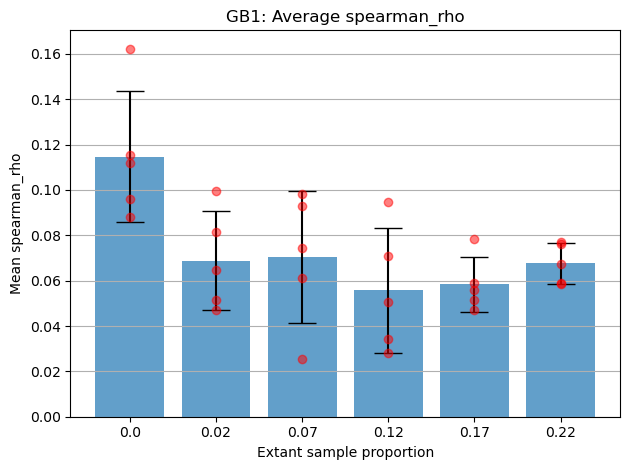

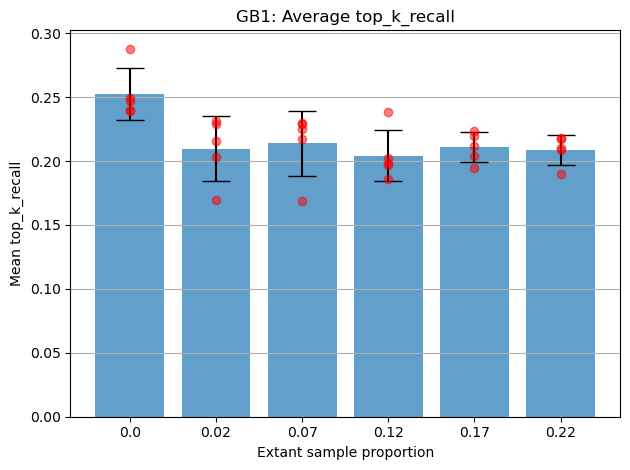

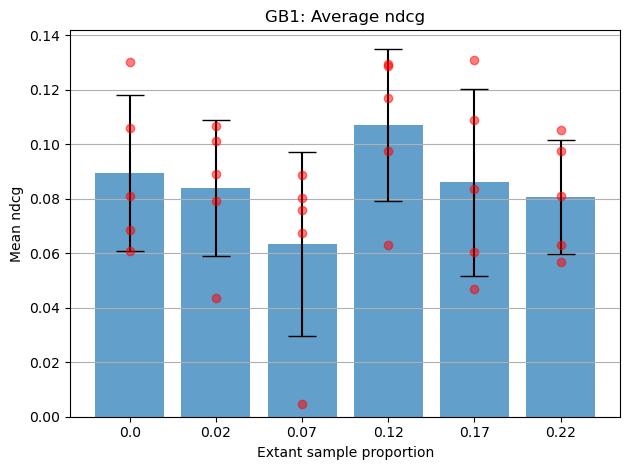

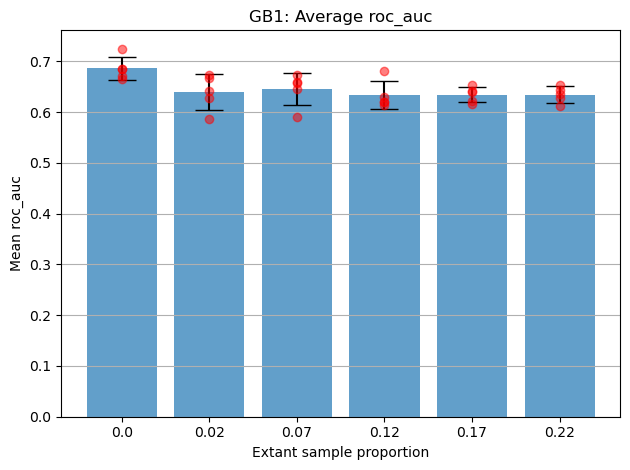

In [41]:
plot_clustering_metrics(gb1_all_cluster_results, "GB1")

# A4 human clustering 

#### A4 clustering results - loss

['a4_0.0', 'a4_0.1', 'a4_0.15', 'a4_0.05', 'a4_0.2185'] ['/Users/sebs_mac/sanj_round_1/a4/a4_0.0_sanjana/', '/Users/sebs_mac/sanj_round_1/a4/a4_0.1_sanjana/', '/Users/sebs_mac/sanj_round_1/a4/a4_0.15_sanjana/', '/Users/sebs_mac/sanj_round_1/a4/a4_0.05_sanjana/', '/Users/sebs_mac/sanj_round_1/a4/a4_0.2185_sanjana/']


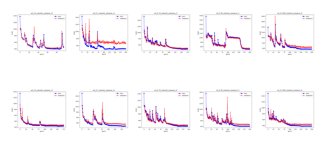

In [48]:
a4_file_path = '/Users/sebs_mac/sanj_round_1/a4/'
figure_name = "a4_cluster_sanj_loss.png"

plot_clustering_loss(a4_file_path, figure_name, rows=2, columns=5, replicates=5)

#### A4 clustering results - metrics: 5 replicates

In [50]:
a4_all_cluster_results = combine_clustering_replicates(a4_file_path, max_reps=5)
a4_all_cluster_results

(25, 5)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc
0,./a4_0.0_extants_sanjana_r1/,0.249754,0.143725,0.602980,0.628919
1,./a4_0.1_extants_sanjana_r1/,0.312332,0.153846,0.663788,0.666292
2,./a4_0.15_extants_sanjana_r1/,0.264407,0.124831,0.605570,0.639894
3,./a4_0.05_extants_sanjana_r1/,0.378374,0.118084,0.527994,0.705361
4,./a4_0.2185_extants_sanjana_r1/,0.371964,0.140351,0.665556,0.694252
5,./a4_0.0_extants_sanjana_r2/,0.410244,0.156545,0.635940,0.714624
6,./a4_0.1_extants_sanjana_r2/,0.428724,0.155870,0.675836,0.722933
7,./a4_0.15_extants_sanjana_r2/,0.299473,0.144399,0.596410,0.654257
8,./a4_0.05_extants_sanjana_r2/,0.397460,0.143050,0.625794,0.710871
9,./a4_0.2185_extants_sanjana_r2/,0.400225,0.108637,0.540890,0.711386


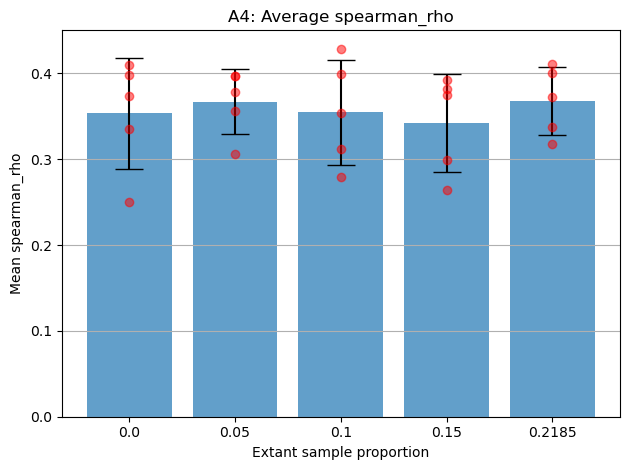

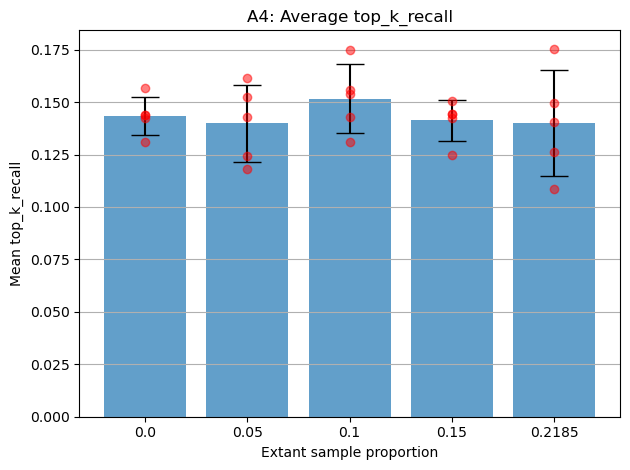

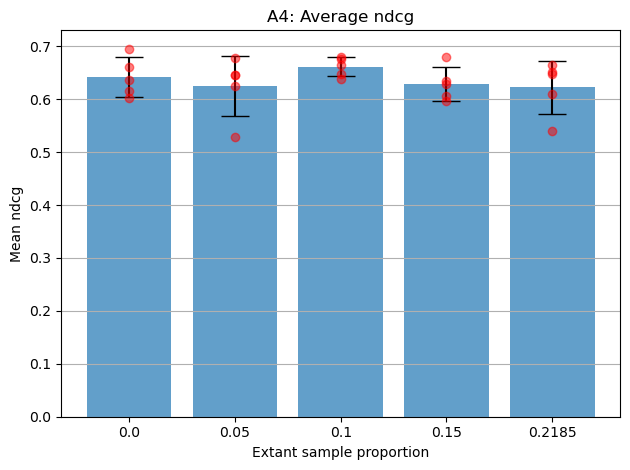

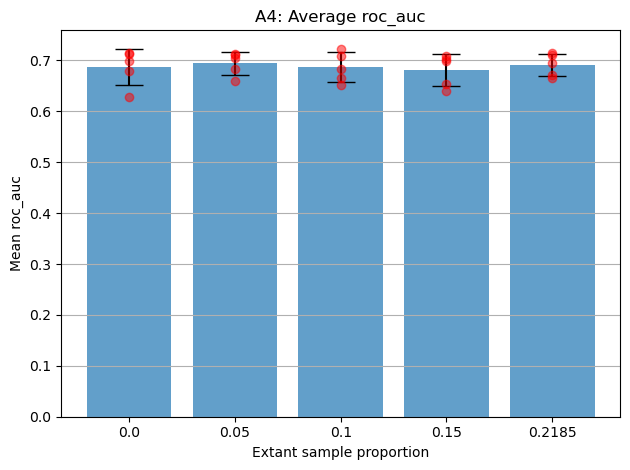

In [51]:
plot_clustering_metrics(a4_all_cluster_results, "A4")

# GCN4 clustering

#### GCN4 clustering results - loss

['gcn4_0.05', 'gcn4_0.0', 'gcn4_0.0662', 'gcn4_0.025', 'gcn4_0.01'] ['/Users/sebs_mac/sanj_round_1/gcn4/gcn4_0.05_sanjana/', '/Users/sebs_mac/sanj_round_1/gcn4/gcn4_0.0_sanjana/', '/Users/sebs_mac/sanj_round_1/gcn4/gcn4_0.0662_sanjana/', '/Users/sebs_mac/sanj_round_1/gcn4/gcn4_0.025_sanjana/', '/Users/sebs_mac/sanj_round_1/gcn4/gcn4_0.01_sanjana/']


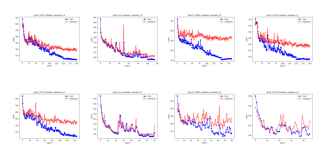

In [54]:
gcn4_file_path = '/Users/sebs_mac/sanj_round_1/gcn4/'
figure_name = "gcn4_cluster_sanj_loss.png"

plot_clustering_loss(gcn4_file_path, figure_name, rows=2, columns=4, replicates=5)

#### GCN4 clustering results - metrics: 15 replicates

In [56]:
gcn4_all_cluster_results = combine_clustering_replicates(gcn4_file_path, max_reps=5)
gcn4_all_cluster_results.head()

(25, 5)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc
0,./gcn4_0.05_extants_sanjana_r1/,0.233578,0.204545,0.453841,0.628593
1,./gcn4_0.0_extants_sanjana_r1/,0.213878,0.181818,0.413704,0.617207
2,./gcn4_0.0662_extants_sanjana_r1/,0.218746,0.204545,0.461973,0.621831
3,./gcn4_0.025_extants_sanjana_r1/,0.209699,0.193182,0.476045,0.615768
4,./gcn4_0.01_extants_sanjana_r1/,0.225693,0.212121,0.435732,0.623312


In [ ]:
gcn4_all_cluster_results

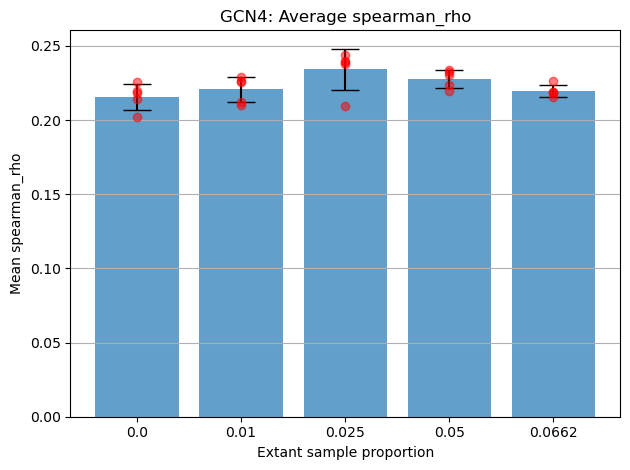

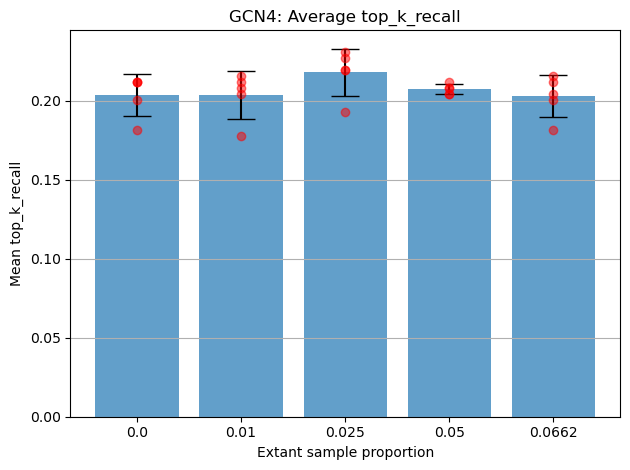

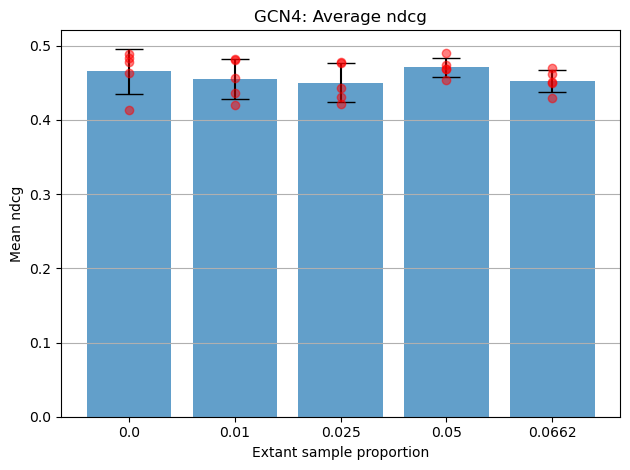

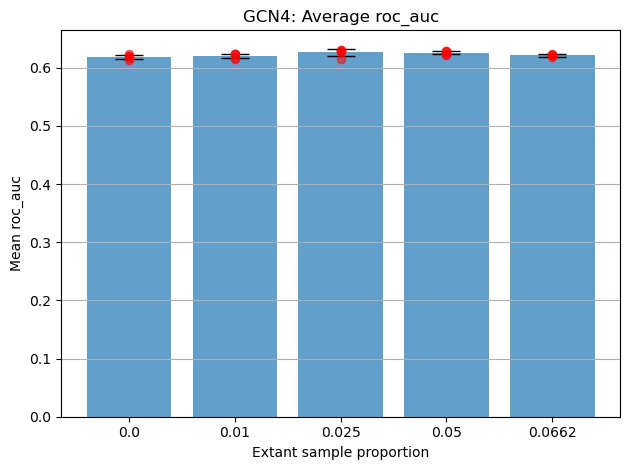

In [57]:
plot_clustering_metrics(gcn4_all_cluster_results, "GCN4")